In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
import os

device = torch.device("cpu")


# =============================================================================
# DEFINE MODEL ARCHITECTURE
# =============================================================================
class AQIClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(AQIClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        
        out = self.fc4(out)
        return out


# =============================================================================
# LOAD MODEL AND PREPROCESSING OBJECTS
# =============================================================================
print("Loading model and preprocessing objects...")

scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

input_size = scaler.n_features_in_
hidden_size1 = 128
hidden_size2 = 128
hidden_size3 = 128
output_size = len(label_encoder.classes_)

model = AQIClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
model.load_state_dict(torch.load('aqi_classifier.pth', map_location=device))
model.eval()
model.to(device)

print("Model loaded successfully!")

Loading model and preprocessing objects...
Model loaded successfully!


# ĐÁNH GIÁ MÔ HÌNH VÀ XỬ LÝ TIF FILES

In [13]:
# =============================================================================
# ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST (DỮ LIỆU CSV)
# =============================================================================

print("="*70)
print("ĐÁNH GIÁ MÔ HÌNH AQI CLASSIFICATION TRÊN TẬP TEST")
print("="*70)

# Đọc dữ liệu test
csv_file = 'data_onkk (2).csv'
df = pd.read_csv(csv_file)
print(f"\nĐã load {len(df)} dòng dữ liệu test từ {csv_file}")

# Tạo AQI_Class từ pm25
def pm25_to_aqi_class(pm25):
    if pm25 <= 15.4:
        return 'Tốt'
    elif pm25 <= 40.4:
        return 'Trung bình'
    elif pm25 <= 65.4:
        return 'Kém'
    elif pm25 <= 150.4:
        return 'Xấu'
    else:
        return 'Rất xấu'

df['AQI_Class'] = df['pm25'].apply(pm25_to_aqi_class)

# Phân bố class trong tập test
print("\nPhân bố AQI class trong tập test:")
print(df['AQI_Class'].value_counts().sort_index())

# Chuẩn bị features và labels
feature_columns = ['PRES2M', 'RH', 'WSPD', 'TMP', 'TP', 'SQRT_SEA_DEM_LAT']
X_test = df[feature_columns]
y_test = df['AQI_Class']

# Chuẩn hóa features
X_test_scaled = scaler.transform(X_test)

# Chuyển sang tensor
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Dự đoán
print("\nĐang dự đoán trên tập test...")
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Chuyển đổi predictions về labels
y_pred = label_encoder.inverse_transform(predicted.cpu().numpy())

# =============================================================================
# CÁC CHỈ SỐ ĐÁNH GIÁ PHÂN LỚP
# =============================================================================
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)

print("\n" + "="*70)
print("CÁC CHỈ SỐ ĐÁNH GIÁ PHÂN LỚP")
print("="*70)

# 1. Accuracy (Độ chính xác tổng thể)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1. ACCURACY (Độ chính xác): {accuracy:.4f} ({accuracy*100:.2f}%)")
print("   → Tỷ lệ dự đoán đúng trên tổng số mẫu test")

# 2. Precision (Độ chính xác của từng class)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"\n2. PRECISION (Độ chính xác từng class):")
print(f"   - Macro avg: {precision_macro:.4f}")
print(f"   - Weighted avg: {precision_weighted:.4f}")
print("   → Trong các mẫu được dự đoán là class X, bao nhiêu % thực sự là X")

# 3. Recall (Độ phủ - Khả năng tìm ra đúng)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"\n3. RECALL (Độ phủ):")
print(f"   - Macro avg: {recall_macro:.4f}")
print(f"   - Weighted avg: {recall_weighted:.4f}")
print("   → Trong tất cả mẫu thực sự là class X, mô hình tìm ra được bao nhiêu %")

# 4. F1-Score (Trung bình điều hòa của Precision và Recall)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"\n4. F1-SCORE (Điểm cân bằng):")
print(f"   - Macro avg: {f1_macro:.4f}")
print(f"   - Weighted avg: {f1_weighted:.4f}")
print("   → Điểm cân bằng giữa Precision và Recall (F1 = 2 * P * R / (P + R))")

# 5. Classification Report chi tiết
print("\n" + "="*70)
print("CLASSIFICATION REPORT CHI TIẾT (Precision, Recall, F1 từng class)")
print("="*70)
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

# 6. Confusion Matrix
print("="*70)
print("CONFUSION MATRIX (Ma trận nhầm lẫn)")
print("="*70)
cm = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
print("\nClasses:", list(label_encoder.classes_))
print("\nMatrix (hàng = thực tế, cột = dự đoán):")
print(cm)

# Tính tỷ lệ dự đoán đúng từng class
print("\nTỷ lệ dự đoán đúng từng class:")
for i, class_name in enumerate(label_encoder.classes_):
    total = cm[i].sum()
    correct = cm[i, i]
    if total > 0:
        print(f"  {class_name}: {correct}/{total} = {correct/total*100:.1f}%")

# =============================================================================
# KẾT LUẬN VÀ LƯU KẾT QUẢ
# =============================================================================
print("\n" + "="*70)
print("KẾT LUẬN")
print("="*70)
print(f"\n✓ Mô hình AQI Classification đạt Accuracy = {accuracy*100:.2f}%")
print(f"✓ F1-Score (weighted) = {f1_weighted:.4f}")
print(f"✓ Precision (weighted) = {precision_weighted:.4f}")
print(f"✓ Recall (weighted) = {recall_weighted:.4f}")

if accuracy >= 0.60:
    print("\n→ MÔ HÌNH TỐT: Accuracy >= 60%, đạt yêu cầu cho việc tạo bản đồ dự báo")
elif accuracy >= 0.50:
    print("\n→ MÔ HÌNH TRUNG BÌNH: Accuracy 50-60%, cần cải thiện nhưng có thể sử dụng")
else:
    print("\n→ MÔ HÌNH CẦN CẢI THIỆN: Accuracy < 50%, nên xem xét fine-tuning")

# Lưu report chi tiết
report_file = 'output_reports/classification_report_notebook.txt'
with open(report_file, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("ĐÁNH GIÁ MÔ HÌNH AQI CLASSIFICATION TRÊN TẬP TEST\n")
    f.write("="*70 + "\n\n")
    f.write(f"Số mẫu test: {len(df)}\n\n")
    f.write("CÁC CHỈ SỐ ĐÁNH GIÁ PHÂN LỚP:\n")
    f.write("-"*70 + "\n")
    f.write(f"1. Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"2. Precision (weighted): {precision_weighted:.4f}\n")
    f.write(f"3. Recall (weighted): {recall_weighted:.4f}\n")
    f.write(f"4. F1-Score (weighted): {f1_weighted:.4f}\n\n")
    f.write("="*70 + "\n")
    f.write("CLASSIFICATION REPORT CHI TIẾT\n")
    f.write("="*70 + "\n")
    f.write(report)
    f.write("\n" + "="*70 + "\n")
    f.write("CONFUSION MATRIX\n")
    f.write("="*70 + "\n")
    f.write(f"Classes: {list(label_encoder.classes_)}\n\n")
    f.write(str(cm))

print(f"\n✓ Đã lưu report chi tiết: {report_file}")
print("\n→ Sử dụng mô hình này để tạo bản đồ dự báo AQI trong cell tiếp theo")


ĐÁNH GIÁ MÔ HÌNH AQI CLASSIFICATION TRÊN TẬP TEST

Đã load 1804 dòng dữ liệu test từ data_onkk (2).csv

Phân bố AQI class trong tập test:
AQI_Class
Kém           425
Rất xấu         9
Trung bình    951
Tốt           251
Xấu           168
Name: count, dtype: int64

Đang dự đoán trên tập test...

CÁC CHỈ SỐ ĐÁNH GIÁ PHÂN LỚP

1. ACCURACY (Độ chính xác): 0.5516 (55.16%)
   → Tỷ lệ dự đoán đúng trên tổng số mẫu test

2. PRECISION (Độ chính xác từng class):
   - Macro avg: 0.6730
   - Weighted avg: 0.6479
   → Trong các mẫu được dự đoán là class X, bao nhiêu % thực sự là X

3. RECALL (Độ phủ):
   - Macro avg: 0.7122
   - Weighted avg: 0.5516
   → Trong tất cả mẫu thực sự là class X, mô hình tìm ra được bao nhiêu %

4. F1-SCORE (Điểm cân bằng):
   - Macro avg: 0.6493
   - Weighted avg: 0.5538
   → Điểm cân bằng giữa Precision và Recall (F1 = 2 * P * R / (P + R))

CLASSIFICATION REPORT CHI TIẾT (Precision, Recall, F1 từng class)
              precision    recall  f1-score   support

         

In [14]:
# =============================================================================
# XỬ LÝ TIF FILES VÀ TẠO BẢN ĐỒ AQI CHO TẤT CẢ CÁC NGÀY
# =============================================================================
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

print("\n" + "="*70)
print("XỬ LÝ TIF FILES VÀ TẠO BẢN ĐỒ AQI")
print("="*70)

# Đường dẫn thư mục chứa TIF files
feature_maps_dir = "Feature_Maps-20251116T094941Z-1-001/Feature_Maps"

# Lấy danh sách các ngày
feature_names = ['PRES2M', 'RH', 'WSPD', 'TMP', 'TP']
sample_dir = os.path.join(feature_maps_dir, feature_names[0])
available_dates = sorted([f.replace(f'{feature_names[0]}_', '').replace('.tif', '') 
                         for f in os.listdir(sample_dir) if f.endswith('.tif')])

print(f"\nCác ngày có sẵn: {available_dates}")
print(f"Sẽ xử lý {len(available_dates)} ngày")

# Đọc SQRT_SEA_DEM_LAT (giống nhau cho tất cả ngày)
sqrt_file = os.path.join(feature_maps_dir, "SQRT_SEA_DEM_LAT.tif")
img = Image.open(sqrt_file)
sqrt_feature = np.array(img)

# Thiết lập màu sắc cho AQI
colors_list = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97']
cmap = mcolors.ListedColormap(colors_list)
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
aqi_value_map = {'Tốt': 1, 'Trung bình': 2, 'Kém': 3, 'Xấu': 4, 'Rất xấu': 5}

# Xử lý từng ngày
all_predictions = []

for date_to_process in available_dates:
    print(f"\n{'='*70}")
    print(f"Xử lý ngày: {date_to_process}")
    print('='*70)
    
    # Đọc các TIF files
    features = {}
    for feature_name in feature_names:
        file_path = os.path.join(feature_maps_dir, feature_name, f"{feature_name}_{date_to_process}.tif")
        img = Image.open(file_path)
        features[feature_name] = np.array(img)
        height, width = features[feature_name].shape
    
    features['SQRT_SEA_DEM_LAT'] = sqrt_feature
    
    # Ghép features
    feature_stack = np.stack([
        features['PRES2M'],
        features['RH'],
        features['WSPD'],
        features['TMP'],
        features['TP'],
        features['SQRT_SEA_DEM_LAT']
    ], axis=-1)
    
    num_pixels = height * width
    feature_matrix = feature_stack.reshape(num_pixels, 6)
    
    # Lọc pixel hợp lệ
    valid_mask = ~np.isnan(feature_matrix).any(axis=1)
    nodata_mask = (feature_matrix == -9999.0).any(axis=1)
    valid_mask = valid_mask & ~nodata_mask
    
    valid_features = feature_matrix[valid_mask]
    valid_indices = np.where(valid_mask)[0]
    
    print(f"Kích thước: {height}x{width}, Pixel hợp lệ: {len(valid_features)} ({100*len(valid_features)/num_pixels:.1f}%)")
    
    # Dự đoán AQI
    scaled_features = scaler.transform(valid_features)
    input_tensor = torch.FloatTensor(scaled_features).to(device)
    
    with torch.no_grad():
        raw_output = model(input_tensor)
        _, predicted_indices = torch.max(raw_output, 1)
    
    predicted_labels = label_encoder.inverse_transform(predicted_indices.cpu().numpy())
    
    # Tạo DataFrame
    df_date = pd.DataFrame({
        'date': date_to_process,
        'pixel_index': valid_indices,
        'row': valid_indices // width,
        'col': valid_indices % width,
        'PRES2M': valid_features[:, 0],
        'RH': valid_features[:, 1],
        'WSPD': valid_features[:, 2],
        'TMP': valid_features[:, 3],
        'TP': valid_features[:, 4],
        'SQRT_SEA_DEM_LAT': valid_features[:, 5],
        'predicted_AQI': predicted_labels
    })
    
    all_predictions.append(df_date)
    
    # Lưu CSV
    output_csv = f'output_csv/TIF_Predictions_{date_to_process}.csv'
    df_date.to_csv(output_csv, index=False)
    
    # Phân bố AQI
    aqi_dist = df_date['predicted_AQI'].value_counts().sort_index()
    print(f"Phân bố AQI: {', '.join([f'{k}={v}' for k, v in aqi_dist.items()])}")
    
    # TẠO BẢN ĐỒ
    print(f"Tạo bản đồ...")
    aqi_map = np.full((height, width), np.nan)
    
    for _, row_data in df_date.iterrows():
        row_idx = int(row_data['row'])
        col_idx = int(row_data['col'])
        aqi_map[row_idx, col_idx] = aqi_value_map[row_data['predicted_AQI']]
    
    # Vẽ
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(aqi_map, cmap=cmap, norm=norm, aspect='auto')
    
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=[1, 2, 3, 4, 5])
    cbar.ax.set_yticklabels(['Tốt', 'Trung bình', 'Kém', 'Xấu', 'Rất xấu'])
    cbar.set_label('AQI Class', rotation=270, labelpad=20, fontsize=12)
    
    date_formatted = f"{date_to_process[:4]}-{date_to_process[4:6]}-{date_to_process[6:8]}"
    ax.set_title(f'Bản đồ AQI từ dữ liệu TIF - {date_formatted}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Kinh độ (pixel)', fontsize=12)
    ax.set_ylabel('Vĩ độ (pixel)', fontsize=12)
    
    info_text = f"Pixel hợp lệ: {len(df_date):,}/{num_pixels:,} ({100*len(df_date)/num_pixels:.1f}%)"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    output_image = f'output_images/AQI_Map_{date_to_process}.png'
    plt.savefig(output_image, dpi=150, bbox_inches='tight')
    print(f"Đã lưu: {output_csv} và {output_image}")
    
    plt.close()

# Lưu tổng hợp
df_predictions = pd.concat(all_predictions, ignore_index=True)
df_predictions.to_csv('output_csv/TIF_Predictions_All_Dates.csv', index=False)

print("\n" + "="*70)
print("HOÀN THÀNH!")
print("="*70)
print(f"Đã xử lý {len(available_dates)} ngày")
print(f"Tổng số dòng dữ liệu: {len(df_predictions):,}")
print(f"Đã tạo {len(available_dates)} file CSV và {len(available_dates)} ảnh bản đồ")


XỬ LÝ TIF FILES VÀ TẠO BẢN ĐỒ AQI

Các ngày có sẵn: ['20200101', '20200529', '20200721', '20200810', '20201015', '20201215']
Sẽ xử lý 6 ngày

Xử lý ngày: 20200101
Kích thước: 81x73, Pixel hợp lệ: 2914 (49.3%)
Phân bố AQI: Kém=155, Rất xấu=218, Trung bình=501, Tốt=80, Xấu=1960
Tạo bản đồ...
Đã lưu: output_csv/TIF_Predictions_20200101.csv và output_images/AQI_Map_20200101.png

Xử lý ngày: 20200529
Kích thước: 81x73, Pixel hợp lệ: 2914 (49.3%)
Phân bố AQI: Kém=984, Trung bình=1704, Tốt=226
Tạo bản đồ...
Đã lưu: output_csv/TIF_Predictions_20200101.csv và output_images/AQI_Map_20200101.png

Xử lý ngày: 20200529
Kích thước: 81x73, Pixel hợp lệ: 2914 (49.3%)
Phân bố AQI: Kém=984, Trung bình=1704, Tốt=226
Tạo bản đồ...
Đã lưu: output_csv/TIF_Predictions_20200529.csv và output_images/AQI_Map_20200529.png

Xử lý ngày: 20200721
Kích thước: 81x73, Pixel hợp lệ: 2914 (49.3%)
Phân bố AQI: Kém=237, Trung bình=1163, Tốt=1514
Tạo bản đồ...
Đã lưu: output_csv/TIF_Predictions_20200529.csv và output_imag

# SO SÁNH: DỰ ĐOÁN PM2.5 QUA MODEL HỒI QUY

In [15]:
# =============================================================================
# DỰ ĐOÁN PM2.5 QUA MODEL HỒI QUY VÀ SO SÁNH VỚI MODEL PHÂN LOẠI
# =============================================================================

print("\n" + "="*70)
print("DỰ ĐOÁN PM2.5 QUA MODEL HỒI QUY")
print("="*70)

# Định nghĩa model PM2.5 Regressor
class PM25Regressor(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, dropout_rate=0.2):
        super(PM25Regressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_size, 1)  # Output 1 giá trị PM2.5
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Load PM2.5 regression model
pm25_model = PM25Regressor(input_size=6, hidden_size=128, dropout_rate=0.2)
pm25_model.load_state_dict(torch.load('pm25_regressor.pth', map_location=device))
pm25_model.eval()
pm25_model.to(device)

print("✓ PM2.5 Regressor model loaded successfully!")

# Hàm chuyển PM2.5 sang AQI class
def pm25_to_aqi_class(pm25):
    if pm25 <= 15.4:
        return 'Tốt'
    elif pm25 <= 40.4:
        return 'Trung bình'
    elif pm25 <= 65.4:
        return 'Kém'
    elif pm25 <= 150.4:
        return 'Xấu'
    else:
        return 'Rất xấu'

# Dự đoán PM2.5 trên tập test
print("\nĐang dự đoán PM2.5 trên tập test...")
with torch.no_grad():
    pm25_outputs = pm25_model(X_test_tensor)
    pm25_predicted = pm25_outputs.cpu().numpy().flatten()

# Chuyển PM2.5 sang AQI class
y_pred_from_pm25 = [pm25_to_aqi_class(pm25) for pm25 in pm25_predicted]

# So sánh hai phương pháp
print("\n" + "="*70)
print("SO SÁNH HAI PHƯƠNG PHÁP DỰ ĐOÁN")
print("="*70)

# Accuracy của từng phương pháp
accuracy_direct = accuracy_score(y_test, y_pred)
accuracy_via_pm25 = accuracy_score(y_test, y_pred_from_pm25)

print(f"\n1. MODEL PHÂN LOẠI TRỰC TIẾP:")
print(f"   Accuracy: {accuracy_direct:.4f} ({accuracy_direct*100:.2f}%)")

print(f"\n2. MODEL HỒI QUY PM2.5 → AQI:")
print(f"   Accuracy: {accuracy_via_pm25:.4f} ({accuracy_via_pm25*100:.2f}%)")

print(f"\n3. CHÊNH LỆCH:")
diff = accuracy_direct - accuracy_via_pm25
print(f"   {diff:+.4f} ({diff*100:+.2f}%)")

if accuracy_direct > accuracy_via_pm25:
    print("\n→ Model phân loại trực tiếp TỐT HƠN")
else:
    print("\n→ Model hồi quy PM2.5 TỐT HƠN")

# Thống kê PM2.5 dự đoán
print("\n" + "="*70)
print("THỐNG KÊ PM2.5 DỰ ĐOÁN")
print("="*70)
print(f"\nMin PM2.5: {pm25_predicted.min():.2f} μg/m³")
print(f"Max PM2.5: {pm25_predicted.max():.2f} μg/m³")
print(f"Mean PM2.5: {pm25_predicted.mean():.2f} μg/m³")
print(f"Median PM2.5: {np.median(pm25_predicted):.2f} μg/m³")

# Phân bố AQI từ PM2.5
print("\nPhân bố AQI class từ PM2.5 dự đoán:")
pm25_aqi_dist = pd.Series(y_pred_from_pm25).value_counts().sort_index()
for class_name, count in pm25_aqi_dist.items():
    percentage = count / len(y_pred_from_pm25) * 100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

# Classification report cho phương pháp PM2.5
print("\n" + "="*70)
print("CLASSIFICATION REPORT - PHƯƠNG PHÁP PM2.5")
print("="*70)
report_pm25 = classification_report(y_test, y_pred_from_pm25, zero_division=0)
print(report_pm25)

# Lưu một vài dự đoán mẫu để kiểm tra
print("\n" + "="*70)
print("MẪU DỰ ĐOÁN (10 mẫu đầu)")
print("="*70)
comparison_df = pd.DataFrame({
    'PM2.5_predicted': pm25_predicted[:10],
    'AQI_from_PM2.5': y_pred_from_pm25[:10],
    'AQI_direct': y_pred[:10],
    'AQI_actual': y_test[:10].values
})
print(comparison_df.to_string())

# Tính tỷ lệ khớp giữa hai phương pháp
agreement = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_pred_from_pm25[i]])
agreement_rate = agreement / len(y_pred) * 100
print(f"\n→ Tỷ lệ khớp giữa 2 phương pháp: {agreement}/{len(y_pred)} = {agreement_rate:.1f}%")


DỰ ĐOÁN PM2.5 QUA MODEL HỒI QUY
✓ PM2.5 Regressor model loaded successfully!

Đang dự đoán PM2.5 trên tập test...

SO SÁNH HAI PHƯƠNG PHÁP DỰ ĐOÁN

1. MODEL PHÂN LOẠI TRỰC TIẾP:
   Accuracy: 0.5516 (55.16%)

2. MODEL HỒI QUY PM2.5 → AQI:
   Accuracy: 0.6059 (60.59%)

3. CHÊNH LỆCH:
   -0.0543 (-5.43%)

→ Model hồi quy PM2.5 TỐT HƠN

THỐNG KÊ PM2.5 DỰ ĐOÁN

Min PM2.5: 7.00 μg/m³
Max PM2.5: 166.61 μg/m³
Mean PM2.5: 30.87 μg/m³
Median PM2.5: 26.50 μg/m³

Phân bố AQI class từ PM2.5 dự đoán:
  Kém: 357 (19.8%)
  Rất xấu: 1 (0.1%)
  Trung bình: 1060 (58.8%)
  Tốt: 313 (17.4%)
  Xấu: 73 (4.0%)

CLASSIFICATION REPORT - PHƯƠNG PHÁP PM2.5
              precision    recall  f1-score   support

         Kém       0.50      0.42      0.45       425
     Rất xấu       1.00      0.11      0.20         9
  Trung bình       0.67      0.75      0.71       951
         Tốt       0.49      0.61      0.55       251
         Xấu       0.67      0.29      0.41       168

    accuracy                        

# ĐÁNH GIÁ CHI TIẾT MODEL HỒI QUY PM2.5


ĐÁNH GIÁ MODEL HỒI QUY PM2.5

Số lượng mẫu test: 1804
PM2.5 thực tế - Min: 3.56, Max: 213.95, Mean: 36.87 μg/m³
PM2.5 dự đoán - Min: 7.00, Max: 166.61, Mean: 30.87 μg/m³

CÁC CHỈ SỐ ĐÁNH GIÁ HỒI QUY

1. MAE (Mean Absolute Error): 11.3581 μg/m³
   → Sai số tuyệt đối trung bình: dự đoán sai lệch trung bình 11.36 μg/m³

2. RMSE (Root Mean Squared Error): 16.5761 μg/m³
   → Độ lệch chuẩn của sai số: phạt nặng các dự đoán sai lệch lớn

3. R² Score: 0.5386
   → Tỷ lệ phương sai được giải thích: 53.86%
   → MÔ HÌNH TRUNG BÌNH: 0.5 <= R² < 0.7

4. MAPE (Mean Absolute Percentage Error): 32.36%
   → Sai số phần trăm trung bình: dự đoán sai lệch trung bình 32.4%

PHÂN TÍCH SAI SỐ (RESIDUALS)
Residual Mean: 6.0065 μg/m³
Residual Std: 15.4496 μg/m³
Residual Min: -67.6852 μg/m³
Residual Max: 133.4821 μg/m³

TẠO BIỂU ĐỒ ĐÁNH GIÁ
✓ Đã lưu biểu đồ: output_reports/pm25_regression_evaluation.png


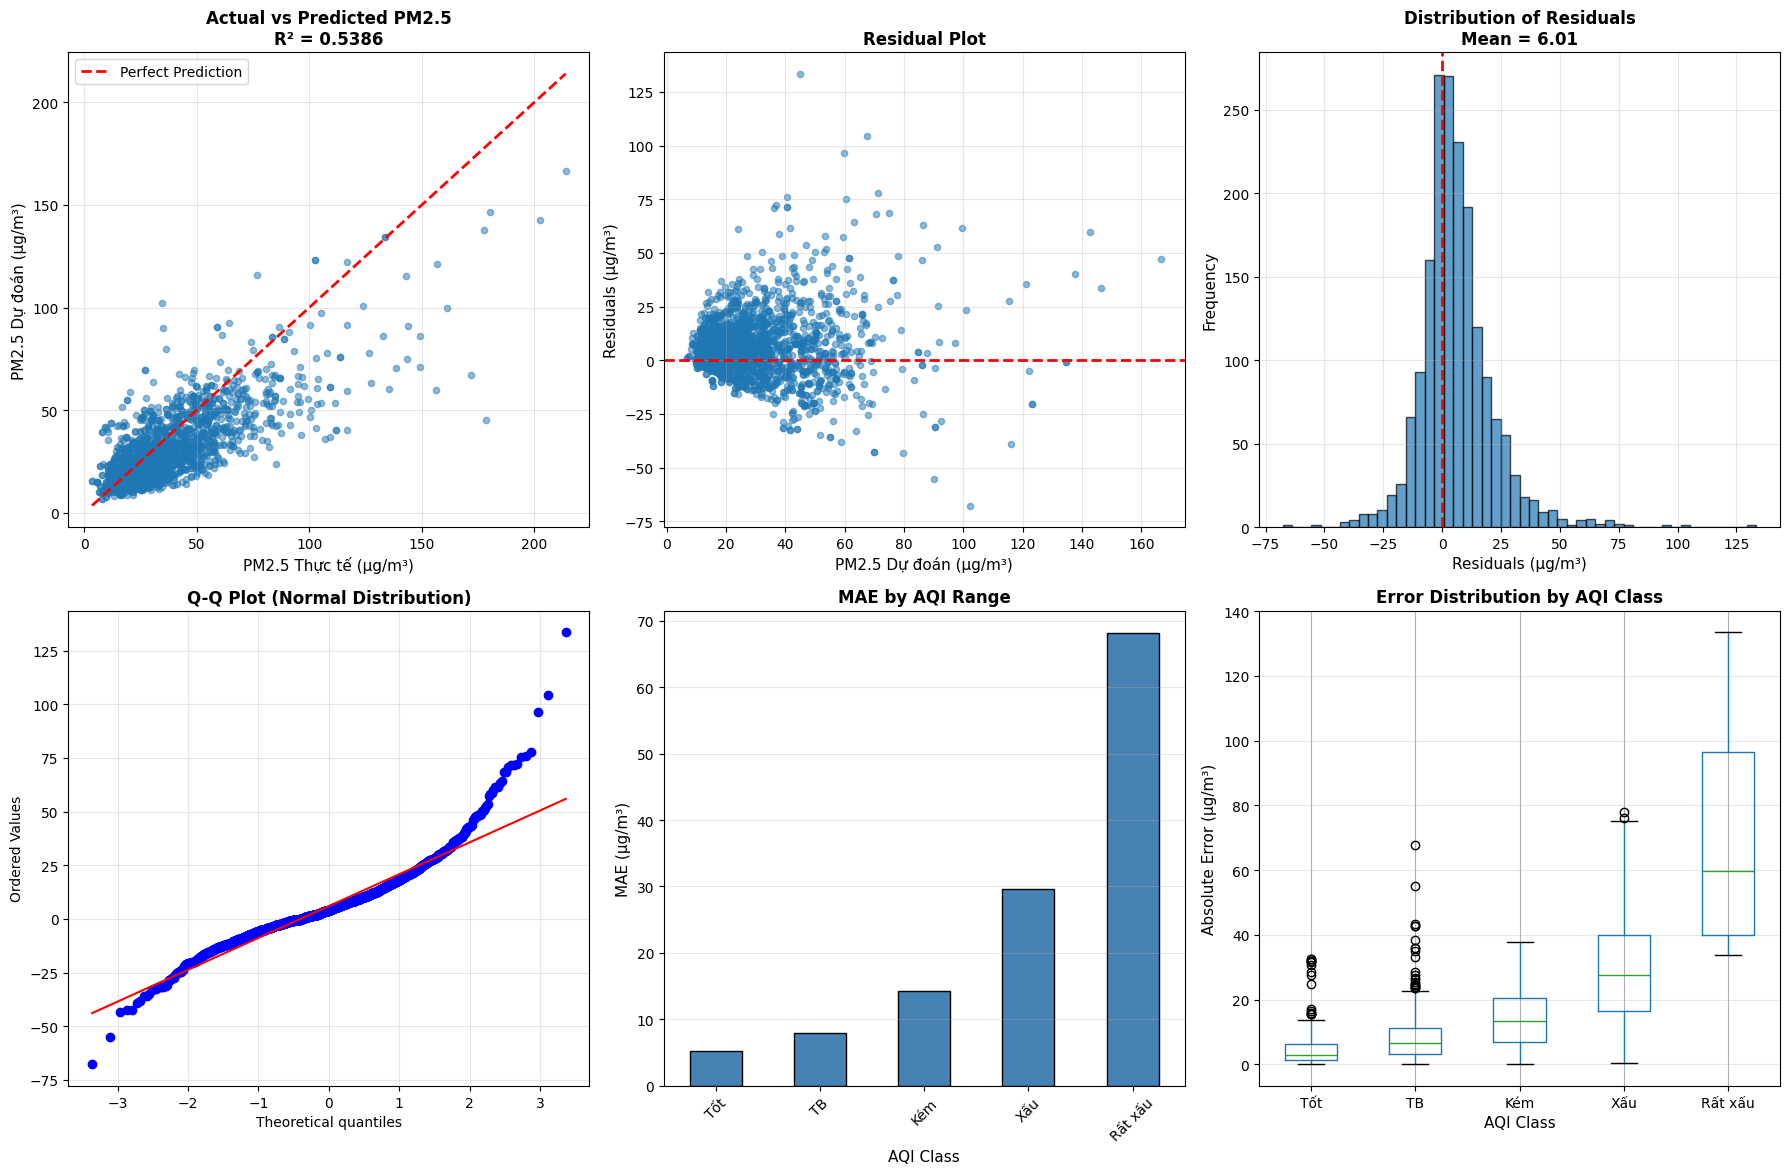


LƯU BÁO CÁO
✓ Đã lưu báo cáo chi tiết: output_reports/pm25_regression_report.txt

TÓM TẮT KẾT QUẢ ĐÁNH GIÁ

📊 CÁC CHỈ SỐ CHÍNH:
   MAE  = 11.36 μg/m³
   RMSE = 16.58 μg/m³
   R²   = 0.5386 (53.9%)
   MAPE = 32.4%

📁 Đã lưu:
   - Báo cáo: output_reports/pm25_regression_report.txt
   - Biểu đồ: output_reports/pm25_regression_evaluation.png


In [17]:
# =============================================================================
# ĐÁNH GIÁ CHI TIẾT MODEL HỒI QUY PM2.5 (REGRESSION METRICS)
# =============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("ĐÁNH GIÁ MODEL HỒI QUY PM2.5")
print("="*70)

# Lấy giá trị PM2.5 thực tế từ tập test
y_test_pm25 = df['pm25'].values

print(f"\nSố lượng mẫu test: {len(y_test_pm25)}")
print(f"PM2.5 thực tế - Min: {y_test_pm25.min():.2f}, Max: {y_test_pm25.max():.2f}, Mean: {y_test_pm25.mean():.2f} μg/m³")
print(f"PM2.5 dự đoán - Min: {pm25_predicted.min():.2f}, Max: {pm25_predicted.max():.2f}, Mean: {pm25_predicted.mean():.2f} μg/m³")

# =============================================================================
# CÁC CHỈ SỐ ĐÁNH GIÁ HỒI QUY
# =============================================================================
print("\n" + "="*70)
print("CÁC CHỈ SỐ ĐÁNH GIÁ HỒI QUY")
print("="*70)

# 1. MAE - Mean Absolute Error
mae = mean_absolute_error(y_test_pm25, pm25_predicted)
print(f"\n1. MAE (Mean Absolute Error): {mae:.4f} μg/m³")
print(f"   → Sai số tuyệt đối trung bình: dự đoán sai lệch trung bình {mae:.2f} μg/m³")

# 2. RMSE - Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test_pm25, pm25_predicted))
print(f"\n2. RMSE (Root Mean Squared Error): {rmse:.4f} μg/m³")
print(f"   → Độ lệch chuẩn của sai số: phạt nặng các dự đoán sai lệch lớn")

# 3. R² Score - Coefficient of Determination
r2 = r2_score(y_test_pm25, pm25_predicted)
print(f"\n3. R² Score: {r2:.4f}")
print(f"   → Tỷ lệ phương sai được giải thích: {r2*100:.2f}%")
if r2 >= 0.7:
    print("   → MÔ HÌNH TỐT: R² >= 0.7")
elif r2 >= 0.5:
    print("   → MÔ HÌNH TRUNG BÌNH: 0.5 <= R² < 0.7")
else:
    print("   → MÔ HÌNH CẦN CẢI THIỆN: R² < 0.5")

# 4. MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test_pm25 - pm25_predicted) / y_test_pm25)) * 100
print(f"\n4. MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"   → Sai số phần trăm trung bình: dự đoán sai lệch trung bình {mape:.1f}%")

# =============================================================================
# PHÂN TÍCH RESIDUALS (SAI SỐ)
# =============================================================================
residuals = y_test_pm25 - pm25_predicted

print("\n" + "="*70)
print("PHÂN TÍCH SAI SỐ (RESIDUALS)")
print("="*70)
print(f"Residual Mean: {residuals.mean():.4f} μg/m³")
print(f"Residual Std: {residuals.std():.4f} μg/m³")
print(f"Residual Min: {residuals.min():.4f} μg/m³")
print(f"Residual Max: {residuals.max():.4f} μg/m³")

# =============================================================================
# VISUALIZATION - TẠO CÁC BIỂU ĐỒ ĐÁNH GIÁ
# =============================================================================
print("\n" + "="*70)
print("TẠO BIỂU ĐỒ ĐÁNH GIÁ")
print("="*70)

fig = plt.figure(figsize=(18, 12))

# 1. Scatter Plot: Actual vs Predicted
ax1 = plt.subplot(2, 3, 1)
plt.scatter(y_test_pm25, pm25_predicted, alpha=0.5, s=20)
plt.plot([y_test_pm25.min(), y_test_pm25.max()], 
         [y_test_pm25.min(), y_test_pm25.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('PM2.5 Thực tế (μg/m³)', fontsize=11)
plt.ylabel('PM2.5 Dự đoán (μg/m³)', fontsize=11)
plt.title(f'Actual vs Predicted PM2.5\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Residual Plot
ax2 = plt.subplot(2, 3, 2)
plt.scatter(pm25_predicted, residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('PM2.5 Dự đoán (μg/m³)', fontsize=11)
plt.ylabel('Residuals (μg/m³)', fontsize=11)
plt.title('Residual Plot', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 3. Histogram of Residuals
ax3 = plt.subplot(2, 3, 3)
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.xlabel('Residuals (μg/m³)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title(f'Distribution of Residuals\nMean = {residuals.mean():.2f}', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 4. Q-Q Plot (Normal Probability Plot)
ax4 = plt.subplot(2, 3, 4)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normal Distribution)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 5. Error by PM2.5 Range
ax5 = plt.subplot(2, 3, 5)
pm25_bins = [0, 15.4, 40.4, 65.4, 150.4, 300]
bin_labels = ['Tốt', 'TB', 'Kém', 'Xấu', 'Rất xấu']
y_test_binned = pd.cut(y_test_pm25, bins=pm25_bins, labels=bin_labels)
error_by_range = pd.DataFrame({'AQI': y_test_binned, 'MAE': np.abs(residuals)})
error_summary = error_by_range.groupby('AQI')['MAE'].mean()
error_summary.plot(kind='bar', ax=ax5, color='steelblue', edgecolor='black')
plt.xlabel('AQI Class', fontsize=11)
plt.ylabel('MAE (μg/m³)', fontsize=11)
plt.title('MAE by AQI Range', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# 6. Box Plot of Errors by AQI Class
ax6 = plt.subplot(2, 3, 6)
error_by_range.boxplot(column='MAE', by='AQI', ax=ax6)
plt.xlabel('AQI Class', fontsize=11)
plt.ylabel('Absolute Error (μg/m³)', fontsize=11)
plt.title('Error Distribution by AQI Class', fontsize=12, fontweight='bold')
plt.suptitle('')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_plot = 'output_reports/pm25_regression_evaluation.png'
plt.savefig(output_plot, dpi=150, bbox_inches='tight')
print(f"✓ Đã lưu biểu đồ: {output_plot}")
plt.show()

# =============================================================================
# LƯU BÁO CÁO CHI TIẾT
# =============================================================================
print("\n" + "="*70)
print("LƯU BÁO CÁO")
print("="*70)

report_file = 'output_reports/pm25_regression_report.txt'
with open(report_file, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("ĐÁNH GIÁ MÔ HÌNH HỒI QUY PM2.5\n")
    f.write("Dự báo nồng độ PM2.5 cho thành phố Hà Nội\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Số mẫu test: {len(y_test_pm25)}\n\n")
    
    f.write("THỐNG KÊ DỮ LIỆU:\n")
    f.write("-"*70 + "\n")
    f.write(f"PM2.5 thực tế:\n")
    f.write(f"  Min: {y_test_pm25.min():.2f} μg/m³\n")
    f.write(f"  Max: {y_test_pm25.max():.2f} μg/m³\n")
    f.write(f"  Mean: {y_test_pm25.mean():.2f} μg/m³\n")
    f.write(f"  Median: {np.median(y_test_pm25):.2f} μg/m³\n\n")
    
    f.write(f"PM2.5 dự đoán:\n")
    f.write(f"  Min: {pm25_predicted.min():.2f} μg/m³\n")
    f.write(f"  Max: {pm25_predicted.max():.2f} μg/m³\n")
    f.write(f"  Mean: {pm25_predicted.mean():.2f} μg/m³\n")
    f.write(f"  Median: {np.median(pm25_predicted):.2f} μg/m³\n\n")
    
    f.write("="*70 + "\n")
    f.write("CÁC CHỈ SỐ ĐÁNH GIÁ HỒI QUY\n")
    f.write("="*70 + "\n")
    f.write(f"1. MAE (Mean Absolute Error): {mae:.4f} μg/m³\n")
    f.write(f"   Sai số tuyệt đối trung bình\n\n")
    
    f.write(f"2. RMSE (Root Mean Squared Error): {rmse:.4f} μg/m³\n")
    f.write(f"   Độ lệch chuẩn của sai số\n\n")
    
    f.write(f"3. R² Score: {r2:.4f} ({r2*100:.2f}%)\n")
    f.write(f"   Tỷ lệ phương sai được giải thích bởi mô hình\n\n")
    
    f.write(f"4. MAPE: {mape:.2f}%\n")
    f.write(f"   Sai số phần trăm tuyệt đối trung bình\n\n")
    
    f.write("="*70 + "\n")
    f.write("PHÂN TÍCH SAI SỐ\n")
    f.write("="*70 + "\n")
    f.write(f"Residual Mean: {residuals.mean():.4f} μg/m³\n")
    f.write(f"Residual Std: {residuals.std():.4f} μg/m³\n")
    f.write(f"Residual Min: {residuals.min():.4f} μg/m³\n")
    f.write(f"Residual Max: {residuals.max():.4f} μg/m³\n\n")
    
    f.write("="*70 + "\n")
    f.write("SAI SỐ TRUNG BÌNH THEO TỪNG MỨC AQI\n")
    f.write("="*70 + "\n")
    for aqi_class in error_summary.index:
        f.write(f"{aqi_class}: {error_summary[aqi_class]:.2f} μg/m³\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("KẾT LUẬN\n")
    f.write("="*70 + "\n")
    f.write(f"✓ Mô hình dự đoán PM2.5 với MAE = {mae:.2f} μg/m³\n")
    f.write(f"✓ RMSE = {rmse:.2f} μg/m³\n")
    f.write(f"✓ R² Score = {r2:.4f} ({r2*100:.2f}%)\n")
    f.write(f"✓ MAPE = {mape:.1f}%\n\n")
    
    if r2 >= 0.7:
        f.write("→ MÔ HÌNH TỐT: R² >= 0.7, giải thích được hơn 70% phương sai\n")
    elif r2 >= 0.5:
        f.write("→ MÔ HÌNH TRUNG BÌNH: 0.5 <= R² < 0.7, cần cải thiện\n")
    else:
        f.write("→ MÔ HÌNH CẦN CẢI THIỆN: R² < 0.5\n")

print(f"✓ Đã lưu báo cáo chi tiết: {report_file}")

# Tóm tắt kết quả
print("\n" + "="*70)
print("TÓM TẮT KẾT QUẢ ĐÁNH GIÁ")
print("="*70)
print(f"\n📊 CÁC CHỈ SỐ CHÍNH:")
print(f"   MAE  = {mae:.2f} μg/m³")
print(f"   RMSE = {rmse:.2f} μg/m³")
print(f"   R²   = {r2:.4f} ({r2*100:.1f}%)")
print(f"   MAPE = {mape:.1f}%")
print(f"\n📁 Đã lưu:")
print(f"   - Báo cáo: {report_file}")
print(f"   - Biểu đồ: {output_plot}")

# TẠO BẢN ĐỒ PM2.5 VÀ AQI TỪ MODEL HỒI QUY

In [16]:
# =============================================================================
# XỬ LÝ TIF FILES VÀ TẠO BẢN ĐỒ PM2.5 + AQI TỪ MODEL HỒI QUY
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

print("\n" + "="*70)
print("XỬ LÝ TIF FILES VÀ TẠO BẢN ĐỒ PM2.5 + AQI (MODEL HỒI QUY)")
print("="*70)

# Tạo thư mục cho kết quả từ model hồi quy
import os
os.makedirs('output_csv_pm25', exist_ok=True)
os.makedirs('output_images_pm25', exist_ok=True)

# Đường dẫn thư mục chứa TIF files
feature_maps_dir = "Feature_Maps-20251116T094941Z-1-001/Feature_Maps"

# Lấy danh sách các ngày
feature_names = ['PRES2M', 'RH', 'WSPD', 'TMP', 'TP']
sample_dir = os.path.join(feature_maps_dir, feature_names[0])
available_dates = sorted([f.replace(f'{feature_names[0]}_', '').replace('.tif', '') 
                         for f in os.listdir(sample_dir) if f.endswith('.tif')])

print(f"\nCác ngày có sẵn: {available_dates}")
print(f"Sẽ xử lý {len(available_dates)} ngày")

# Đọc SQRT_SEA_DEM_LAT
sqrt_file = os.path.join(feature_maps_dir, "SQRT_SEA_DEM_LAT.tif")
img = Image.open(sqrt_file)
sqrt_feature = np.array(img)

# Thiết lập màu sắc cho AQI
colors_list = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97']
cmap = mcolors.ListedColormap(colors_list)
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
aqi_value_map = {'Tốt': 1, 'Trung bình': 2, 'Kém': 3, 'Xấu': 4, 'Rất xấu': 5}

# Xử lý từng ngày
all_predictions_pm25 = []

for date_to_process in available_dates:
    print(f"\n{'='*70}")
    print(f"Xử lý ngày: {date_to_process}")
    print('='*70)
    
    # Đọc các TIF files
    features = {}
    for feature_name in feature_names:
        file_path = os.path.join(feature_maps_dir, feature_name, f"{feature_name}_{date_to_process}.tif")
        img = Image.open(file_path)
        features[feature_name] = np.array(img)
        height, width = features[feature_name].shape
    
    features['SQRT_SEA_DEM_LAT'] = sqrt_feature
    
    # Ghép features
    feature_stack = np.stack([
        features['PRES2M'],
        features['RH'],
        features['WSPD'],
        features['TMP'],
        features['TP'],
        features['SQRT_SEA_DEM_LAT']
    ], axis=-1)
    
    num_pixels = height * width
    feature_matrix = feature_stack.reshape(num_pixels, 6)
    
    # Lọc pixel hợp lệ
    valid_mask = ~np.isnan(feature_matrix).any(axis=1)
    nodata_mask = (feature_matrix == -9999.0).any(axis=1)
    valid_mask = valid_mask & ~nodata_mask
    
    valid_features = feature_matrix[valid_mask]
    valid_indices = np.where(valid_mask)[0]
    
    print(f"Kích thước: {height}x{width}, Pixel hợp lệ: {len(valid_features)} ({100*len(valid_features)/num_pixels:.1f}%)")
    
    # DỰ ĐOÁN PM2.5 QUA MODEL HỒI QUY
    scaled_features = scaler.transform(valid_features)
    input_tensor = torch.FloatTensor(scaled_features).to(device)
    
    with torch.no_grad():
        pm25_output = pm25_model(input_tensor)
        pm25_values = pm25_output.cpu().numpy().flatten()
    
    # Chuyển PM2.5 sang AQI class
    aqi_labels = [pm25_to_aqi_class(pm25) for pm25 in pm25_values]
    
    # Tạo DataFrame với PM2.5 và AQI
    df_date = pd.DataFrame({
        'date': date_to_process,
        'pixel_index': valid_indices,
        'row': valid_indices // width,
        'col': valid_indices % width,
        'PRES2M': valid_features[:, 0],
        'RH': valid_features[:, 1],
        'WSPD': valid_features[:, 2],
        'TMP': valid_features[:, 3],
        'TP': valid_features[:, 4],
        'SQRT_SEA_DEM_LAT': valid_features[:, 5],
        'predicted_PM25': pm25_values,
        'predicted_AQI': aqi_labels
    })
    
    all_predictions_pm25.append(df_date)
    
    # Lưu CSV
    output_csv = f'output_csv_pm25/TIF_Predictions_PM25_{date_to_process}.csv'
    df_date.to_csv(output_csv, index=False)
    
    # Thống kê PM2.5
    print(f"PM2.5: Min={pm25_values.min():.2f}, Max={pm25_values.max():.2f}, Mean={pm25_values.mean():.2f} μg/m³")
    
    # Phân bố AQI
    aqi_dist = df_date['predicted_AQI'].value_counts().sort_index()
    print(f"Phân bố AQI: {', '.join([f'{k}={v}' for k, v in aqi_dist.items()])}")
    
    # ============================================
    # TẠO 3 BẢN ĐỒ: PM2.5, AQI VÀ COMPOSITE
    # ============================================
    
    # 1. BẢN ĐỒ PM2.5 (màu liên tục)
    print(f"Tạo bản đồ PM2.5...")
    pm25_map = np.full((height, width), np.nan)
    
    for _, row_data in df_date.iterrows():
        row_idx = int(row_data['row'])
        col_idx = int(row_data['col'])
        pm25_map[row_idx, col_idx] = row_data['predicted_PM25']
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(pm25_map, cmap='YlOrRd', vmin=0, vmax=150, aspect='auto')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('PM2.5 (μg/m³)', rotation=270, labelpad=20, fontsize=12)
    
    date_formatted = f"{date_to_process[:4]}-{date_to_process[4:6]}-{date_to_process[6:8]}"
    ax.set_title(f'Bản đồ PM2.5 (Model Hồi Quy) - {date_formatted}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Kinh độ (pixel)', fontsize=12)
    ax.set_ylabel('Vĩ độ (pixel)', fontsize=12)
    
    info_text = f"PM2.5: {pm25_values.mean():.1f}±{pm25_values.std():.1f} μg/m³\n"
    info_text += f"Pixel: {len(df_date):,}/{num_pixels:,}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    output_image = f'output_images_pm25/PM25_Map_{date_to_process}.png'
    plt.savefig(output_image, dpi=150, bbox_inches='tight')
    plt.close()
    
    # 2. BẢN ĐỒ AQI (màu rời rạc)
    print(f"Tạo bản đồ AQI từ PM2.5...")
    aqi_map = np.full((height, width), np.nan)
    
    for _, row_data in df_date.iterrows():
        row_idx = int(row_data['row'])
        col_idx = int(row_data['col'])
        aqi_map[row_idx, col_idx] = aqi_value_map[row_data['predicted_AQI']]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(aqi_map, cmap=cmap, norm=norm, aspect='auto')
    
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=[1, 2, 3, 4, 5])
    cbar.ax.set_yticklabels(['Tốt', 'Trung bình', 'Kém', 'Xấu', 'Rất xấu'])
    cbar.set_label('AQI Class', rotation=270, labelpad=20, fontsize=12)
    
    ax.set_title(f'Bản đồ AQI từ PM2.5 (Model Hồi Quy) - {date_formatted}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Kinh độ (pixel)', fontsize=12)
    ax.set_ylabel('Vĩ độ (pixel)', fontsize=12)
    
    info_text = f"PM2.5 mean: {pm25_values.mean():.1f} μg/m³\n"
    info_text += f"Pixel: {len(df_date):,}/{num_pixels:,}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    output_image = f'output_images_pm25/AQI_Map_from_PM25_{date_to_process}.png'
    plt.savefig(output_image, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Đã lưu: {output_csv}, PM25_Map_{date_to_process}.png, AQI_Map_from_PM25_{date_to_process}.png")

# Lưu tổng hợp
df_predictions_pm25 = pd.concat(all_predictions_pm25, ignore_index=True)
df_predictions_pm25.to_csv('output_csv_pm25/TIF_Predictions_PM25_All_Dates.csv', index=False)

print("\n" + "="*70)
print("HOÀN THÀNH - MODEL HỒI QUY PM2.5!")
print("="*70)
print(f"Đã xử lý {len(available_dates)} ngày")
print(f"Tổng số dòng dữ liệu: {len(df_predictions_pm25):,}")
print(f"Đã tạo:")
print(f"  - {len(available_dates)} file CSV (với PM2.5 và AQI)")
print(f"  - {len(available_dates)} bản đồ PM2.5")
print(f"  - {len(available_dates)} bản đồ AQI")

# Thống kê tổng quan PM2.5
print("\n" + "="*70)
print("THỐNG KÊ TỔNG QUAN PM2.5")
print("="*70)
print(f"PM2.5 toàn bộ dữ liệu:")
print(f"  Min: {df_predictions_pm25['predicted_PM25'].min():.2f} μg/m³")
print(f"  Max: {df_predictions_pm25['predicted_PM25'].max():.2f} μg/m³")
print(f"  Mean: {df_predictions_pm25['predicted_PM25'].mean():.2f} μg/m³")
print(f"  Median: {df_predictions_pm25['predicted_PM25'].median():.2f} μg/m³")

print("\nPhân bố AQI toàn bộ:")
total_aqi_dist = df_predictions_pm25['predicted_AQI'].value_counts().sort_index()
for class_name, count in total_aqi_dist.items():
    percentage = count / len(df_predictions_pm25) * 100
    print(f"  {class_name}: {count:,} ({percentage:.1f}%)")


XỬ LÝ TIF FILES VÀ TẠO BẢN ĐỒ PM2.5 + AQI (MODEL HỒI QUY)

Các ngày có sẵn: ['20200101', '20200529', '20200721', '20200810', '20201015', '20201215']
Sẽ xử lý 6 ngày

Xử lý ngày: 20200101
Kích thước: 81x73, Pixel hợp lệ: 2914 (49.3%)
PM2.5: Min=46.82, Max=179.72, Mean=95.43 μg/m³
Phân bố AQI: Kém=294, Rất xấu=80, Xấu=2540
Tạo bản đồ PM2.5...
Tạo bản đồ AQI từ PM2.5...
Đã lưu: output_csv_pm25/TIF_Predictions_PM25_20200101.csv, PM25_Map_20200101.png, AQI_Map_from_PM25_20200101.png

Xử lý ngày: 20200529
Kích thước: 81x73, Pixel hợp lệ: 2914 (49.3%)
PM2.5: Min=12.97, Max=114.64, Mean=34.35 μg/m³
Phân bố AQI: Kém=449, Trung bình=2204, Tốt=64, Xấu=197
Tạo bản đồ PM2.5...
Tạo bản đồ AQI từ PM2.5...
Đã lưu: output_csv_pm25/TIF_Predictions_PM25_20200529.csv, PM25_Map_20200529.png, AQI_Map_from_PM25_20200529.png

Xử lý ngày: 20200721
Kích thước: 81x73, Pixel hợp lệ: 2914 (49.3%)
PM2.5: Min=8.90, Max=91.50, Mean=25.81 μg/m³
Phân bố AQI: Kém=254, Trung bình=1836, Tốt=742, Xấu=82
Tạo bản đồ PM2.5..